# Machine learning
Tutta la parte dedicata al machine learning (regressione + classificazione) verrà scritta qui

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import pickle

#sklearn
#from sklearn.preprocessing import OneHotEncoder

# custom lib
import sys
sys.path.append('./../src')


import make_dataset as m_d
import ML_functions as supp_ML
# seed originario 86122330
np.random.seed(86122330)

# PRIMA TASK: prevedere l'attività di twitter a livello provinciale

In [4]:
# Importo i dati dal database finale (vedi Import Dati)
data = pd.read_csv(m_d.data_path_out / 'MachineLearningDB.csv')

# Smisto target e features
target_mattina = data['TargetDay']
target_sera = data['TargetNight']
data.drop(columns=['TargetDay', 'TargetNight'], inplace=True)


"""
#### PROBLEMA: questo encodda il weekday ma non lo svolge in colonne
#### (non è bello svolgerlo, e poco generale maybe)
# Encoder sul dato categorico weekday
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
data["Weekday"]=enc.fit_transform(data["Weekday"].values[:,None]).tolist()

NOTA: se inserisco un np.array(np.array) ad un dataframe MI TIENE SOLO PRIMO ELEMENTO (1.0<=>'Mo')
 Se converto a lista funziona

Nota: equivale a
data['Weekday'] = enc.fit(data["Weekday"].values[:,None])
data['Weekday'] = enc.transform(data["Weekday"].values[:,None]).tolist()

Nota: Per convertire i contenuti a np.array(), ma comunque non fa funzionare sklearn
temp=enc.fit_transform(data["Weekday"].values[:,None])
data["Weekday"]=[np.array(i) for i in temp]
"""

"""
# Facendo make_column_transformer funziona, ma meglio inserirlo nella pipeline
colTr = make_column_transformer( (StandardScaler(), ["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n",
                                                     "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n"]),
                                (OneHotEncoder(), ['Weekday']), remainder='passthrough')


#Restringere database di features, molte delle features ipotizzate contano poco, ed ho molti pochi dati
data=data[["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n", "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n", "Weekday"]]

#enc=OneHotEncoder(sparse=False, handle_unknown='ignore')
data=colTr.fit_transform(data)
data
"""
num_feat=["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n", "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n"]
cat_feat=["Weekday"]

data[num_feat+cat_feat].head(6)



,Tweet1m,Tweet2m,Tweet1n,Tweet2n,Tavg1m,Tavg2m,Tavg1n,Tavg2n,Weekday
0,149,165,44,92,11.245556,12.132153,9.895139,10.252631,Su
1,115,149,74,44,12.137079,11.245556,7.764167,9.895139,Mo
2,90,115,54,74,7.444653,12.137079,6.732540,7.764167,Tu
3,106,90,56,54,10.234794,7.444653,6.847639,6.732540,We
4,102,106,55,56,10.780688,10.234794,6.581250,6.847639,Th
5,88,102,92,55,10.987268,10.780688,6.968611,6.581250,Fr


In [5]:
#MATTINA:
PL_Matt_Logistic=supp_ML.logistic_regressor_fittato(data, target_mattina, num_feat, cat_feat)
PL_Matt_RF=supp_ML.Random_Forest_Regressor_CV(data, target_mattina, num_feat, cat_feat)

Logistic regression r2_score = 0.3928198052884144
Random forest r2_score =  0.4729625222709424
Random forest (gridSearchCV) r2_score =  0.5965676476187041


In [7]:
# salvo i dati
filename1 = 'Finalized_Logistic_morning.sav'
filename2 = 'Finalized_RF_morning.sav'
pickle.dump(PL_Matt_Logistic, open(filename1, 'wb'))
pickle.dump(PL_Matt_RF, open(filename2, 'wb'))

Nota: se tolgo handle_unknown="ignore" dal one hot encoder raisa un messaggio di errore a volte (dipende dal random seed del problema), il seed 86122330 attiva il problema (eseguendo il notebook in ordine). \
Vista la soluzione al problema si penserebbe che sia un problema del one hot encoder, ma non vedo perchè dovrebbe **a volte** fallire. L'unica cosa che ho pensato era "forse nell'insieme di train non ci sono tutti i giorni della settimana", ma printare
```python
PL_Matt_RF["transformer"].transformers_[1][1].categories_
```
oppure (se uso il gridsearch)
```python
PL_Matt_RF.best_estimator_["transformer"].transformers_[1][1].categories_
```
dimostra che questo non è il problema. Il warning è raisato nella parte di CV durante il fit \
Nota: l'errore contiene 432 NaNs, che sono i 432 candidati della gridsearch (in teoria); non so se implichi qualcosa questo \
Nota: se faccio l'ignore aumenta drasticamente l'r2, probabilmente perchè aumentano di molto i punti di training

## Osservazioni:
**Regressione:** altissima varianza valore r2, ho molti pochi dati per fare questa stima (also, ci sono i dati del fine anno e delle feste che sballano tutto) \
**Random Forest:** piuttosto stabile nonostante lo scarso numero di dati (as predicted), sicuramente better-than-random ma visto il basso numero di dati non riscontriamo successi strepitosi



In [9]:
#SERA
PL_Sera_Logistic=supp_ML.logistic_regressor_fittato(data, target_sera, num_feat, cat_feat)
PL_Sera_RF=supp_ML.Random_Forest_Regressor_CV(data, target_sera, num_feat, cat_feat)

#More of the same, niente di strano

Logistic regression r2_score = -0.011681645677269259
Random forest r2_score =  0.24978353295653544
Random forest (gridSearchCV) r2_score =  0.4716935789521335


In [10]:
# salvo i dati
filename1 = 'Finalized_Logistic_evening.sav'
filename2 = 'Finalized_RF_evening.sav'
pickle.dump(PL_Sera_Logistic, open(filename1, 'wb'))
pickle.dump(PL_Sera_RF, open(filename2, 'wb'))

# SECONDA TASK: identificare la circoscrizione con più tweets associati

In [12]:
# creo il vettore delle y trovando qual è la circoscrizione più attiva
targetCirc = supp_ML.circoscrizione_attiva(m_d.data_path_out / "twitter_final.csv")
targetCirc = pd.Series(targetCirc)
targetCirc.drop([targetCirc.index[0], targetCirc.index[1]], inplace=True)
targetCirc.unique()  #Ho solo 2 valori rilevanti
print(Counter(targetCirc))
print('Le classi sono palesemente sbilanciati nel momento in cui facciamo un train/test split')

Counter({'CENTRO STORICO PIEDICASTELLO': 47, 'OLTREFERSINA': 12})
Le classi sono palesemente sbilanciati nel momento in cui facciamo un train/test split


Lo score della nostra Random Forest risulta essere: 0.8333333333333334 per il riconoscimento delle circoscrizioni più attive


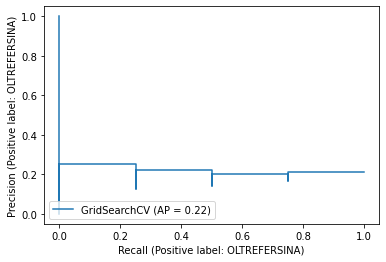

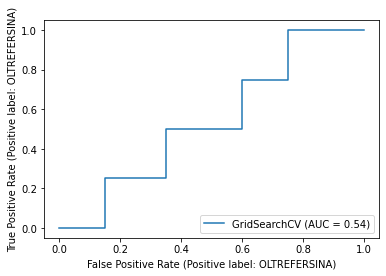

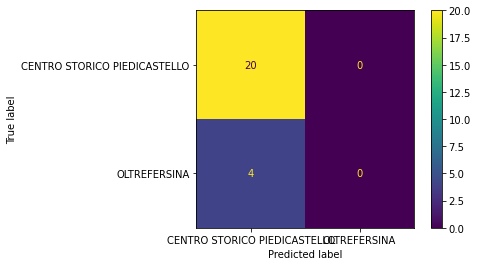

In [13]:
# Random Forest Classifier
PL_classPred=supp_ML.Random_Forest_Classifier_Circoscrizione(data, targetCirc, num_feat, cat_feat)

#~75% di accuracy non fa neanche troppo schifo

In [14]:
filename1 = 'Circoscrizioni.sav'
pickle.dump(PL_classPred, open(filename1, 'wb'))

In [6]:
data


,Tweet1m,Tweet2m,Tavg1m,Tavg2m,Rainmax1m,Rainmax2m,Rainavg1m,Rainavg2m,Electro1m,Electro2m,...,Tweet2n,Tavg1n,Tavg2n,Rainmax1n,Rainmax2n,Rainavg1n,Rainavg2n,Electro1n,Electro2n,Weekday
0,149,165,11.245556,12.132153,0.050,0.005,0.002222,0.000139,327834.111688,292081.262027,...,92,9.895139,10.252631,0.050,0.005,0.000000,0.000278,147530.373514,146824.968450,Su
1,115,149,12.137079,11.245556,0.295,0.050,0.017409,0.002222,289288.545583,327834.111688,...,44,7.764167,9.895139,0.295,0.050,0.000278,0.000000,142660.468535,147530.373514,Mo
2,90,115,7.444653,12.137079,0.380,0.295,0.087083,0.017409,492895.718458,289288.545583,...,74,6.732540,7.764167,0.380,0.295,0.035357,0.000278,181140.198258,142660.468535,Tu
3,106,90,10.234794,7.444653,0.055,0.380,0.001532,0.087083,455374.880566,492895.718458,...,54,6.847639,6.732540,0.055,0.380,0.000000,0.035357,182369.053078,181140.198258,We
4,102,106,10.780688,10.234794,0.065,0.055,0.002782,0.001532,460321.190708,455374.880566,...,56,6.581250,6.847639,0.065,0.055,0.000000,0.000000,183050.783353,182369.053078,Th
5,88,102,10.987268,10.780688,0.000,0.065,0.000000,0.002782,453392.307536,460321.190708,...,55,6.968611,6.581250,0.000,0.065,0.000000,0.000000,182702.993196,183050.783353,Fr
6,150,88,10.084236,10.987268,0.060,0.000,0.005000,0.000000,489172.850505,453392.307536,...,92,8.877778,6.968611,0.060,0.000,0.061389,0.000000,178196.248176,182702.993196,Sa
7,274,150,9.349038,10.084236,2.340,0.060,0.302550,0.005000,369908.844959,489172.850505,...,108,6.211996,8.877778,2.340,0.060,0.300941,0.061389,150375.870312,178196.248176,Su
8,165,274,6.068681,9.349038,0.200,2.340,0.011389,0.302550,293029.836887,369908.844959,...,91,6.006944,6.211996,0.200,2.340,0.005556,0.300941,149437.308492,150375.870312,Mo
9,190,165,9.110903,6.068681,0.090,0.200,0.002778,0.011389,486685.277024,293029.836887,...,132,7.035278,6.006944,0.090,0.200,0.000000,0.005556,189104.348406,149437.308492,Tu
